# 星巴克毕业项目

### 简介

这个数据集是一些模拟 Starbucks rewards 移动 app 上用户行为的数据。每隔几天，星巴克会向 app 的用户发送一些推送。这个推送可能仅仅是一条饮品的广告或者是折扣券或 BOGO（买一送一）。一些顾客可能一连几周都收不到任何推送。 

顾客收到的推送可能是不同的，这就是这个数据集的挑战所在。

你的任务是将交易数据、人口统计数据和推送数据结合起来判断哪一类人群会受到某种推送的影响。这个数据集是从星巴克 app 的真实数据简化而来。因为下面的这个模拟器仅产生了一种饮品， 实际上星巴克的饮品有几十种。

每种推送都有有效期。例如，买一送一（BOGO）优惠券推送的有效期可能只有 5 天。你会发现数据集中即使是一些消息型的推送都有有效期，哪怕这些推送仅仅是饮品的广告，例如，如果一条消息型推送的有效期是 7 天，你可以认为是该顾客在这 7 天都可能受到这条推送的影响。

数据集中还包含 app 上支付的交易信息，交易信息包括购买时间和购买支付的金额。交易信息还包括该顾客收到的推送种类和数量以及看了该推送的时间。顾客做出了购买行为也会产生一条记录。 

同样需要记住有可能顾客购买了商品，但没有收到或者没有看推送。

### 示例

举个例子，一个顾客在周一收到了满 10 美元减 2 美元的优惠券推送。这个推送的有效期从收到日算起一共 10 天。如果该顾客在有效日期内的消费累计达到了 10 美元，该顾客就满足了该推送的要求。

然而，这个数据集里有一些地方需要注意。即，这个推送是自动生效的；也就是说，顾客收到推送后，哪怕没有看到，满足了条件，推送的优惠依然能够生效。比如，一个顾客收到了"满10美元减2美元优惠券"的推送，但是该用户在 10 天有效期内从来没有打开看到过它。该顾客在 10 天内累计消费了 15 美元。数据集也会记录他满足了推送的要求，然而，这个顾客并没被受到这个推送的影响，因为他并不知道它的存在。

### 清洗

清洗数据非常重要也非常需要技巧。

你也要考虑到某类人群即使没有收到推送，也会购买的情况。从商业角度出发，如果顾客无论是否收到推送都打算花 10 美元，你并不希望给他发送满 10 美元减 2 美元的优惠券推送。所以你可能需要分析某类人群在没有任何推送的情况下会购买什么。

### 最后一项建议

因为这是一个毕业项目，你可以使用任何你认为合适的方法来分析数据。例如，你可以搭建一个机器学习模型来根据人口统计数据和推送的种类来预测某人会花费多少钱。或者，你也可以搭建一个模型来预测该顾客是否会对推送做出反应。或者，你也可以完全不用搭建机器学习模型。你可以开发一套启发式算法来决定你会给每个顾客发出什么样的消息（比如75% 的35 岁女性用户会对推送 A 做出反应，对推送 B 则只有 40% 会做出反应，那么应该向她们发送推送 A）。


# 数据集

一共有三个数据文件：

* portfolio.json – 包括推送的 id 和每个推送的元数据（持续时间、种类等等）
* profile.json – 每个顾客的人口统计数据
* transcript.json – 交易、收到的推送、查看的推送和完成的推送的记录

以下是文件中每个变量的类型和解释 ：

**portfolio.json**
* id (string) – 推送的id
* offer_type (string) – 推送的种类，例如 BOGO、打折（discount）、信息（informational）
* difficulty (int) – 满足推送的要求所需的最少花费
* reward (int) – 满足推送的要求后给与的优惠
* duration (int) – 推送持续的时间，单位是天
* channels (字符串列表)

**profile.json**
* age (int) – 顾客的年龄 
* became_member_on (int) – 该顾客第一次注册app的时间
* gender (str) – 顾客的性别（注意除了表示男性的 M 和表示女性的 F 之外，还有表示其他的 O）
* id (str) – 顾客id
* income (float) – 顾客的收入

**transcript.json**
* event (str) – 记录的描述（比如交易记录、推送已收到、推送已阅）
* person (str) – 顾客id
* time (int) – 单位是小时，测试开始时计时。该数据从时间点 t=0 开始
* value - (dict of strings) – 推送的id 或者交易的数额


In [1]:
import math
import json
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, classification_report
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1.浏览数据（数据理解）


### 1.1 portfolio.json 数据浏览

In [3]:
# 数据量
portfolio.shape

(10, 6)

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# channels类型
channel_list = []
for item in portfolio['channels']:
    channel_list += item
channel_list = list(set(channel_list))
print(channel_list)

['mobile', 'social', 'web', 'email']


In [6]:
list(portfolio.difficulty.unique())

[10, 0, 5, 20, 7]

In [7]:
list(portfolio.offer_type.unique())

['bogo', 'informational', 'discount']

In [8]:
list(portfolio.reward.unique())

[10, 0, 5, 3, 2]

### 1.2 profile.json数据

In [9]:
# 数据浏览
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
# 数据量
profile.shape

(17000, 5)

In [11]:
# 缺失值数量
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [12]:
# 性别和收入均缺失的数据量
profile[profile['gender'].isnull() & profile['income'].isnull()].shape[0]

2175

In [13]:
# 性别和收入均缺失，且年龄为118的数据量
profile[(profile['age']==118) & profile['gender'].isnull() & profile['income'].isnull()].shape[0]

2175

In [14]:
# 顾客年龄统计
profile.age.describe()

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

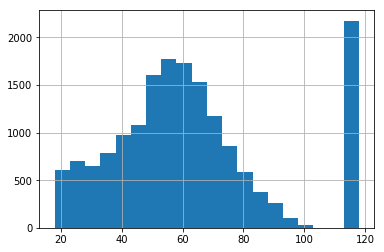

In [15]:
# 年龄分布直方图
profile.age.hist(bins=20)

In [16]:
# 人数最多的5个年龄值
profile.age.value_counts().head()

118    2175
58      408
53      372
51      363
54      359
Name: age, dtype: int64

年龄118岁的顾客人数最多，这显然不合理，可能是年龄选项的上限是118，许多顾客随意填写了上限值，数据处理时，应排除这些年龄数据。

In [17]:
# 最早会员注册日
profile.became_member_on.min()

20130729

In [18]:
# 最晚会员注册日
profile.became_member_on.max()

20180726

In [19]:
# 用户性别统计
profile['gender'].value_counts(dropna=False)

M      8484
F      6129
NaN    2175
O       212
Name: gender, dtype: int64

In [20]:
# 用户收入统计
profile.income.describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

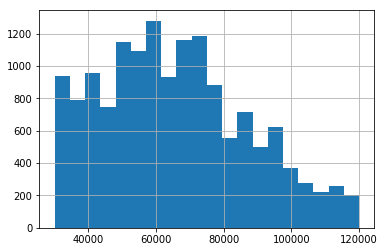

In [21]:
# 收入分布直方图
profile.income.hist(bins=20)

In [22]:
#不同性别顾客收入情况
profile[['gender', 'income']].groupby('gender').describe()

income                                                         \
         count          mean           std      min      25%      50%   
gender                                                                  
F       6129.0  71306.412139  22338.353773  30000.0  54000.0  71000.0   
M       8484.0  61194.601603  20069.517615  30000.0  45000.0  59000.0   
O        212.0  63287.735849  18938.594726  30000.0  51000.0  62000.0   

                           
            75%       max  
gender                     
F       88000.0  120000.0  
M       73000.0  120000.0  
O       79250.0  100000.0

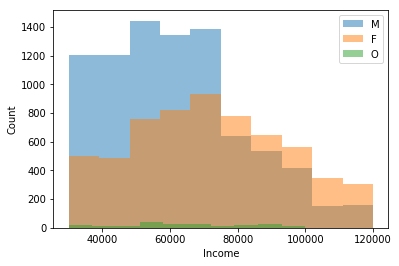

In [23]:
plt.hist(profile[profile.gender == 'M']['income'], alpha=0.5, label='M')
plt.hist(profile[profile.gender == 'F']['income'], alpha=0.5, label='F')
plt.hist(profile[profile.gender == 'O']['income'], alpha=0.5, label='O')
plt.xlabel('Income')
plt.ylabel('Count')
plt.legend()
plt.show()

### 1.3 transcript.json 数据

In [24]:
# 数据预览
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:
# 记录数量
transcript.shape

(306534, 4)

In [26]:
# 不同类别数据量
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

No handles with labels found to put in legend.


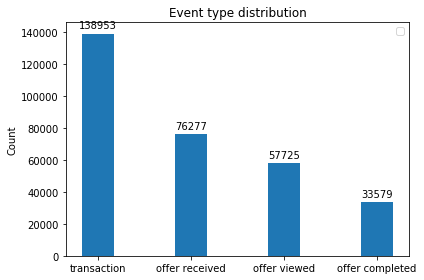

In [27]:
labels = transcript.event.value_counts().index
data = transcript.event.value_counts()

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, data, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Count')
ax.set_title('Event type distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
autolabel(rects1)
fig.tight_layout()
plt.show()

In [28]:
# 顾客人数
transcript.person.unique().shape[0]

17000

In [29]:
# 测试时间统计
transcript.time.describe()

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

In [30]:
# 收到推送事件浏览
transcript[transcript['event']=='offer received'].head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [31]:
# 推送已阅事件浏览
transcript[transcript['event']=='offer viewed'].head()

,event,person,time,value
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651,offer viewed,d1ede868e29245ea91818a903fec04c6,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652,offer viewed,102e9454054946fda62242d2e176fdce,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653,offer viewed,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655,offer viewed,be8a5d1981a2458d90b255ddc7e0d174,0,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}


In [32]:
# 推送完成事件浏览
transcript[transcript['event']=='offer completed'].head()

,event,person,time,value
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672,offer completed,fe97aa22dd3e48c8b143116a8403dd52,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679,offer completed,629fc02d56414d91bca360decdfa9288,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692,offer completed,676506bad68e4161b9bbaffeb039626b,0,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697,offer completed,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...


In [33]:
transcript[transcript['event']=='offer completed'].shape

(33579, 4)

In [34]:
# 交易事件浏览
transcript[transcript['event']=='transaction'].head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


查看用户'78afa995795e4d85b5d9ceeca43f5fef'记录：

In [35]:
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


查看用户'68617ca6246f4fbc85e91a2a49552598'记录：

In [36]:
transcript[transcript['person']=='68617ca6246f4fbc85e91a2a49552598']

,event,person,time,value
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
38221,offer viewed,68617ca6246f4fbc85e91a2a49552598,84,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
53178,offer received,68617ca6246f4fbc85e91a2a49552598,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
118294,offer received,68617ca6246f4fbc85e91a2a49552598,336,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
130149,offer viewed,68617ca6246f4fbc85e91a2a49552598,348,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
132802,transaction,68617ca6246f4fbc85e91a2a49552598,354,{'amount': 0.19}
158119,offer received,68617ca6246f4fbc85e91a2a49552598,408,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
177263,offer viewed,68617ca6246f4fbc85e91a2a49552598,432,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
201576,offer received,68617ca6246f4fbc85e91a2a49552598,504,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
289715,offer viewed,68617ca6246f4fbc85e91a2a49552598,648,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


观察后可知，用户可能收到offer后并不浏览，或浏览后并不交易，也可能没有收到offer时消费，同时在一次消费中可能会使用2个offer的优惠。

## 2.数据准备（预处理）与进一步分析

### 2.1 portfolio 数据预处理
#### 2.1.1 将channels转化为one-hot形式

In [37]:
def one_hot_channels(portfolio_df, channel_list):
    '''
    one hot encoded channels columns
    '''
    for channel in channel_list:
        portfolio_df[channel] = portfolio_df.channels.apply(lambda x: 1 if channel in x else 0)

    #drop channels column
    portfolio_df = portfolio_df.drop('channels', axis=1)
    
    return portfolio_df

portfolio = one_hot_channels(portfolio, channel_list)
portfolio

,difficulty,duration,id,offer_type,reward,mobile,social,web,email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,0,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,0,1,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,0,1,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,0,1,1
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,0,1,1


#### 2.1.1 将offer_type转化为one-hot形式

In [38]:
portfolio = pd.get_dummies(portfolio, columns=['offer_type'])
portfolio

,difficulty,duration,id,reward,mobile,social,web,email,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,0,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,0,1,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,0,1,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,1,1,0,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,0,1,1,0,1,0


### 2.2 profile 数据预处理
#### 2.2.1 缺失值数据处理
之前数据浏览中，已经发现性别缺失的，同样其收入也缺失，且其年龄为118。后续需注意这部分无效数据。

In [39]:
# 将年龄为118的更改为None
profile.loc[lambda x: x['age'] == 118, 'age'] = None

In [40]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


#### 2.2.2 处理age数据

In [41]:
def divide_into_groups_dummies(df, column, interval):
    '''
    divide values into several groups accourding to the interval，and transfer to one-hot style
    df : (dataframe)
    column : (str)
    interval ：（int）
    return:(dataframe)
    '''
    df['temp'] = df.apply(lambda x: None if pd.isnull(x[column]) else np.floor(x[column]/interval).astype(int), axis=1)
    df = pd.get_dummies(df, columns=['temp'], prefix=column)
    return df

In [42]:
# 将年龄按10岁间隔分组，转化为one-hot形式
profile = divide_into_groups_dummies(profile, 'age', 10)
profile.head()

,age,became_member_on,gender,id,income,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,age_9.0,age_10.0
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0,0,0,0,0,0,0
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,0,0
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0,0,0,0,0,0,0
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,0,0
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0,0,0,0,0,0,0


#### 2.2.3 处理became_member_on数据

In [43]:
# 将became_member_on转化为datetime类型
profile['became_member_on'] = pd.to_datetime(profile.became_member_on.astype(str))
profile.head()

,age,became_member_on,gender,id,income,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,age_9.0,age_10.0
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0,0,0,0,0,0,0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,0,0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0,0,0,0,0,0,0
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,0,0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0,0,0,0,0,0,0


In [44]:
# 新增became_member_yeaer列
profile['became_member_year'] = profile['became_member_on'].apply(lambda x: x.year)
profile.head()

,age,became_member_on,gender,id,income,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,age_7.0,age_8.0,age_9.0,age_10.0,became_member_year
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0,0,0,0,0,0,0,2017
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,0,0,0,0,2017
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0,0,0,0,0,0,0,2018
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,1,0,0,0,2017
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0,0,0,0,0,0,0,2017


In [45]:
# 将became_member_yeaer转换为one-hot形式
profile = pd.get_dummies(profile, columns=['became_member_year'])
profile.head()

,age,became_member_on,gender,id,income,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,...,age_7.0,age_8.0,age_9.0,age_10.0,became_member_year_2013,became_member_year_2014,became_member_year_2015,became_member_year_2016,became_member_year_2017,became_member_year_2018
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


#### 2.2.4 将gender转化为one-hot形式

In [46]:
profile = pd.get_dummies(profile, columns=['gender'])
profile.head()

,age,became_member_on,id,income,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,...,age_10.0,became_member_year_2013,became_member_year_2014,became_member_year_2015,became_member_year_2016,became_member_year_2017,became_member_year_2018,gender_F,gender_M,gender_O
0,NaN,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,NaN,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,NaN,2017-08-04,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### 2.2.5 将income转化为one-hot形式

In [47]:
# 将收入按10000间隔分组，转化为one-hot形式
profile = divide_into_groups_dummies(profile, 'income', 10000)
profile.head()

,age,became_member_on,id,income,age_1.0,age_2.0,age_3.0,age_4.0,age_5.0,age_6.0,...,income_3.0,income_4.0,income_5.0,income_6.0,income_7.0,income_8.0,income_9.0,income_10.0,income_11.0,income_12.0
0,NaN,2017-02-12,68be06ca386d4c31939f3a4f0e3dd783,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,55.0,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,NaN,2018-07-12,38fe809add3b4fcf9315a9694bb96ff5,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,75.0,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,NaN,2017-08-04,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2.3 transcript 数据预处理与进一步分析
#### 2.3.1 提取并处理transaction数据

In [48]:
# 提取transaction 数据
transaction = transcript[transcript['event']=='transaction'].copy().reset_index(drop=True)
transaction.head()

,event,person,time,value
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
2,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [49]:
transaction.shape

(138953, 4)

In [50]:
# 新增amount列
transaction['amount'] = transaction['value'].apply(lambda x:x['amount'])
transaction = transaction.drop(['value'], axis=1)
transaction.head()

,event,person,time,amount
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,0.83
1,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56
2,transaction,54890f68699049c2a04d415abc25e717,0,13.23
3,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51
4,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,18.97


In [51]:
# 交易金额统计分析
transaction.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

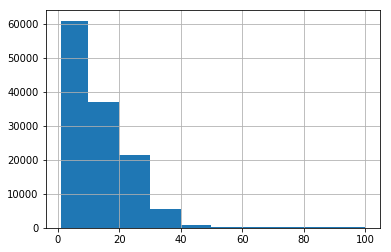

In [52]:
# 交易金额分布直方图
transaction.amount.hist(bins=[1, 10, 20, 30, 40, 50, 100])

In [53]:
transaction.person.unique().shape[0]

16578

按顾客统计交易情况

In [54]:
transaction_by_person = transaction.groupby('person').amount.sum()

In [55]:
transaction_by_person.head()

person
0009655768c64bdeb2e877511632db8f    127.60
00116118485d4dfda04fdbaba9a87b5c      4.09
0011e0d4e6b944f998e987f904e8c1e5     79.46
0020c2b971eb4e9188eac86d93036a77    196.86
0020ccbbb6d84e358d3414a3ff76cffd    154.05
Name: amount, dtype: float64

In [56]:
transaction_by_person.describe()

count    16578.000000
mean       107.096874
std        126.393939
min          0.050000
25%         23.682500
50%         72.410000
75%        150.937500
max       1608.690000
Name: amount, dtype: float64

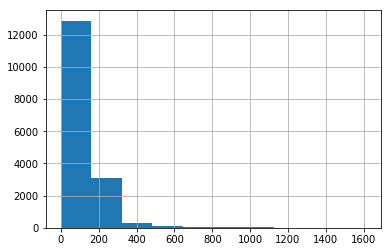

In [57]:
transaction_by_person.hist(bins=10)

#### 2.3.2 处理其他类型事件数据

In [58]:
# 提取除transaction外其他类型事件数据
# transcript = transcript[transcript['event'] != 'transaction']
transcript = transcript.loc[lambda df: df['event']!='transaction', :]
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [59]:
# 新增offerId列
# 注意value中有部分key是‘offer_id’而不是‘offer id’
transcript['offerId'] = transcript['value'].apply(lambda x:x.get('offer id') if x.get('offer id') else x.get('offer_id'))
# 删除value列
transcript = transcript.drop(['value'], axis=1)
transcript.head()

,event,person,time,offerId
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [60]:
# 检查是否有空值
transcript['offerId'].isnull().sum()

0

In [61]:
# 推送的id数与portfolio中推送id比较
set(transcript.offerId) == set(portfolio.id)

True

由以上分析可知推送的id数与portfolio中一致。

In [62]:
# 将同一用户的同一个offer的不同事件情况合并到一行中

In [63]:
# 提取某类型事件，并将“time”列更名为“该事件名+time”命名的列
def get_events(df, event_value, new_name):
    '''
    get one type of events and rename column "time"
    df:(pd.DataFrame)
    event_value:(str)event
    new_name: (str)the new column name
    return:(pd.DataFrame)
    '''
    temp = df[df['event']==event_value].copy()
#     temp[new_name] = 1
    temp = temp.rename(columns={"time": new_name+"_time"})
    temp = temp.drop(['event'], axis=1)
    return temp

In [64]:
# 提取offer_received类型事件
offer_received = get_events(transcript, "offer received", "offer_received")
offer_received.head()

,person,offer_received_time,offerId
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [65]:
offer_received.shape

(76277, 3)

In [66]:
# 提取offer_viewed类型事件
offer_viewed = get_events(transcript, "offer viewed", "offer_viewed")
offer_viewed.head()

,person,offer_viewed_time,offerId
12650,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d
12651,d1ede868e29245ea91818a903fec04c6,0,5a8bc65990b245e5a138643cd4eb9837
12652,102e9454054946fda62242d2e176fdce,0,4d5c57ea9a6940dd891ad53e9dbe8da0
12653,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
12655,be8a5d1981a2458d90b255ddc7e0d174,0,5a8bc65990b245e5a138643cd4eb9837


In [67]:
offer_viewed.shape

(57725, 3)

In [68]:
# 提取offer_completed类型事件
offer_completed = get_events(transcript, "offer completed", "offer_completed")
offer_completed.head()

,person,offer_completed_time,offerId
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [69]:
offer_completed.shape

(33579, 3)

分析分离的推送接收、浏览和完成数据

In [70]:
# 将person与offerId联合作为keys
offer_received['keys'] = offer_received.apply(lambda x: x['person'] + x['offerId'], axis=1)
offer_viewed['keys'] = offer_viewed.apply(lambda x: x['person'] + x['offerId'], axis=1)
offer_completed['keys'] = offer_completed.apply(lambda x: x['person'] + x['offerId'], axis=1)

In [71]:
received_but_not_viewed = set(offer_received['keys']) - set(offer_viewed['keys'])
len(received_but_not_viewed)

14153

In [72]:
received_but_not_completed = set(offer_received['keys']) - set(offer_completed['keys'])
len(received_but_not_completed)

34292

In [73]:
viewed_but_not_received = set(offer_viewed['keys']) - set(offer_received['keys'])
len(viewed_but_not_received)

0

In [74]:
viewed_but_not_completed = set(offer_viewed['keys']) - set(offer_completed['keys'])
len(viewed_but_not_completed)

24675

In [75]:
completed_but_not_received = set(offer_completed['keys']) - set(offer_received['keys'])
len(completed_but_not_received)

0

In [76]:
completed_but_not_viewed = set(offer_completed['keys']) - set(offer_viewed['keys'])
len(completed_but_not_viewed)

4536

查看用户a03223e636434f42ac4c3df47e8bac43推送情况

In [77]:
offer_received[offer_received['person']=='a03223e636434f42ac4c3df47e8bac43']

,person,offer_received_time,offerId,keys
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...
110829,a03223e636434f42ac4c3df47e8bac43,336,3f207df678b143eea3cee63160fa8bed,a03223e636434f42ac4c3df47e8bac433f207df678b143...
150599,a03223e636434f42ac4c3df47e8bac43,408,5a8bc65990b245e5a138643cd4eb9837,a03223e636434f42ac4c3df47e8bac435a8bc65990b245...
201573,a03223e636434f42ac4c3df47e8bac43,504,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...
245125,a03223e636434f42ac4c3df47e8bac43,576,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...


In [78]:
offer_viewed[offer_viewed['person']=='a03223e636434f42ac4c3df47e8bac43']

,person,offer_viewed_time,offerId,keys
15562,a03223e636434f42ac4c3df47e8bac43,6,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...
123539,a03223e636434f42ac4c3df47e8bac43,336,3f207df678b143eea3cee63160fa8bed,a03223e636434f42ac4c3df47e8bac433f207df678b143...
281785,a03223e636434f42ac4c3df47e8bac43,624,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...


In [79]:
offer_completed[offer_completed['person']=='a03223e636434f42ac4c3df47e8bac43']

,person,offer_completed_time,offerId,keys


由以上分析可知，用户查看、完成的推送，一定在其接收的推送中，但是接收的推送不一定会被用户查看和完成，同时用户完成的推送不一定被用户查看过。

In [80]:
def get_time(from_df, time_in_from_df, to_df=offer_received, time_in_to_df='offer_received_time', duration_col_name='duration'):
    '''
    Match items in from_df to to_df according to person&offerId and calculate the time duration.
    If more than one item in to_df matches the item in to_df, only match the latest one.
    from_df:(pd,DataFrame)
    to_df:(pd,DataFrame)
    time_name:(str)column name in to_df
    new_time_name
    '''
    df = to_df.copy()
    df[duration_col_name] = None
    for _, row in from_df.iterrows():    
        person = row['person']
        offerId = row['offerId']
        from_time = row[time_in_from_df]
        rec_time_lst = list(df[(df['person'] == person) & (df['offerId'] == offerId)][time_in_to_df])
        if rec_time_lst:
    #         print("rec_time_lst: {}".format(rec_time_lst))
            time_btw_lst = [(from_time - time) for time in rec_time_lst if (from_time - time >= 0)]
    #         print("time_btw_rec_view_lst: {}".format(time_btw_rec_view_lst))
            if time_btw_lst:
                time_btw = np.min(time_btw_lst)
    #             print("time_btw_rec_view: {}".format(time_btw_rec_view))
                df.loc[lambda df:((df['person'] == person) & (df['offerId'] == offerId) & (
                    df[time_in_to_df] == (int(from_time - time_btw)))), duration_col_name] = time_btw
    return df

In [81]:
# 增加列time_btw_rec_view（收到推送到阅读推送之间的时间间隔）
df = get_time(from_df=offer_viewed, time_in_from_df='offer_viewed_time', duration_col_name='time_btw_rec_view')

In [82]:
df.head(10)

,person,offer_received_time,offerId,keys,time_btw_rec_view
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5cf19421c1d4aa40...,0
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,c4863c7985cf408faee930f111475da32298d6c36e964a...,24
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d3f207df678b143...,None
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e10b1e1539f2cc45...,18
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c530b1e1539f2cc45...,150


In [83]:
df.shape

(76277, 5)

In [84]:
# 检查空值
df.isnull().sum()

person                     0
offer_received_time        0
offerId                    0
keys                       0
time_btw_rec_view      18552
dtype: int64

In [85]:
# 增加列'time_btw_rec_cmpt'（收到推送到完成推送之间的时间间隔）
df = get_time(from_df=offer_completed, to_df=df, time_in_from_df='offer_completed_time', duration_col_name='time_btw_rec_cmpt')

In [86]:
df.head(10)

,person,offer_received_time,offerId,keys,time_btw_rec_view,time_btw_rec_cmpt
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6,132
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6,None
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18,None
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12,None
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84,None
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5cf19421c1d4aa40...,0,60
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,c4863c7985cf408faee930f111475da32298d6c36e964a...,24,None
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d3f207df678b143...,None,None
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e10b1e1539f2cc45...,18,None
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c530b1e1539f2cc45...,150,None


In [87]:
df.shape

(76277, 6)

In [88]:
# 检查空值
df.isnull().sum()

person                     0
offer_received_time        0
offerId                    0
keys                       0
time_btw_rec_view      18552
time_btw_rec_cmpt      43176
dtype: int64

In [89]:
# 保存处理好的交易数据
with open('./data/transcript_new.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df, f, pickle.HIGHEST_PROTOCOL)

In [90]:
# 增加'offer_viewed'列，标记该条推送是否被浏览
df['offer_viewed'] = df.apply(lambda x: 0 if pd.isnull(x['time_btw_rec_view']) else 1, axis=1)
# 增加'offer_completed'列，标记该条推送是否被完成
df['offer_completed'] = df.apply(lambda x: 0 if pd.isnull(x['time_btw_rec_cmpt']) else 1, axis=1)

In [91]:
df.head()

,person,offer_received_time,offerId,keys,time_btw_rec_view,time_btw_rec_cmpt,offer_viewed,offer_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6,132,1,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6,None,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18,None,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12,None,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84,None,1,0


In [92]:
# 将不同推送的有效期存入字典中
duration = dict()
for offerId in portfolio['id']:
    duration[offerId] = int(portfolio[portfolio['id'] == offerId]['duration'])
# duration

In [93]:
# 定义函数，检查时间是否在推送有效期内，None和超过有效期均无效
def time_validation(row, time, duration):
    '''
    Check offer time validation, out of offer duration or None is invalid
    row:(pd.Series)
    time:(str)time column name
    duration:(dict)valid duration dict
    return:(int)(0,1) 1 for valid, 0 for invalid
    '''
    if pd.isnull(row[time]) or row[time]/24 > duration[row['offerId']]:
        return 0
    return 1

In [94]:
# 计算offer_completed到offer_received的时间有效性
df['time_btw_rec_cmpt_valid'] = df.apply(time_validation, axis=1, args=['time_btw_rec_cmpt', duration])
df.head(10)

,person,offer_received_time,offerId,keys,time_btw_rec_view,time_btw_rec_cmpt,offer_viewed,offer_completed,time_btw_rec_cmpt_valid
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6,132,1,1,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6,None,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18,None,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12,None,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84,None,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5cf19421c1d4aa40...,0,60,1,1,1
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,c4863c7985cf408faee930f111475da32298d6c36e964a...,24,None,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d3f207df678b143...,None,None,0,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e10b1e1539f2cc45...,18,None,1,0,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c530b1e1539f2cc45...,150,None,1,0,0


In [95]:
# 查看offer completed中是否存在超过时间有效期的数据
(df["offer_completed"] != df["time_btw_rec_cmpt_valid"]).sum()

0

In [96]:
# 计算offer_viewed到offer_received的时间有效性
df['time_btw_rec_view_valid'] = df.apply(time_validation, axis=1, args=['time_btw_rec_view', duration])
df.head(10)

,person,offer_received_time,offerId,keys,time_btw_rec_view,time_btw_rec_cmpt,offer_viewed,offer_completed,time_btw_rec_cmpt_valid,time_btw_rec_view_valid
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6,132,1,1,1,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6,None,1,0,0,1
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18,None,1,0,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12,None,1,0,0,1
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84,None,1,0,0,1
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5cf19421c1d4aa40...,0,60,1,1,1,1
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,c4863c7985cf408faee930f111475da32298d6c36e964a...,24,None,1,0,0,1
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,2eeac8d8feae4a8cad5a6af0499a211d3f207df678b143...,None,None,0,0,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,aa4862eba776480b8bb9c68455b8c2e10b1e1539f2cc45...,18,None,1,0,0,1
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,31dda685af34476cad5bc968bdb01c530b1e1539f2cc45...,150,None,1,0,0,1


In [97]:
# 查看offer viewed中是否存在超过时间有效期的数据
(df["offer_viewed"] != df["time_btw_rec_view_valid"]).sum()

1158

In [98]:
# 增加'viewed_before_completed'列，标记该条推送完成前是否别浏览
df['viewed_before_completed'] = df.apply(lambda x: 0 if (pd.isnull(x['time_btw_rec_view']) or pd.isnull(x['time_btw_rec_cmpt']) 
      or x['time_btw_rec_view'] > x['time_btw_rec_cmpt']) else 1, axis=1)

In [99]:
df.head()

,person,offer_received_time,offerId,keys,time_btw_rec_view,time_btw_rec_cmpt,offer_viewed,offer_completed,time_btw_rec_cmpt_valid,time_btw_rec_view_valid,viewed_before_completed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6,132,1,1,1,1,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6,None,1,0,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18,None,1,0,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12,None,1,0,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84,None,1,0,0,1,0


### 2.4 整合数据
#### 2.4.1 将portfolio合并入整理好的数据中

In [100]:
df_merged = pd.merge(df, portfolio, left_on='offerId', right_on='id', how='left')
df_merged.head()

,person,offer_received_time,offerId,keys,time_btw_rec_view,time_btw_rec_cmpt,offer_viewed,offer_completed,time_btw_rec_cmpt_valid,time_btw_rec_view_valid,...,duration,id,reward,mobile,social,web,email,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6,132,1,1,1,1,...,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,0,1,1,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6,None,1,0,0,1,...,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,0,0,1,1,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18,None,1,0,0,1,...,7,2906b810c7d4411798c6938adc9daaa5,2,1,0,1,1,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12,None,1,0,0,1,...,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84,None,1,0,0,1,...,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0


In [101]:
df_merged.shape

(76277, 22)

#### 2.4.2 将profile合并入整理好的数据中

In [102]:
df_merged = pd.merge(df_merged, profile, left_on='person', right_on='id', how='left')
df_merged.head()

,person,offer_received_time,offerId,keys,time_btw_rec_view,time_btw_rec_cmpt,offer_viewed,offer_completed,time_btw_rec_cmpt_valid,time_btw_rec_view_valid,...,income_3.0,income_4.0,income_5.0,income_6.0,income_7.0,income_8.0,income_9.0,income_10.0,income_11.0,income_12.0
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef9b98b8c7a33c4b...,6,132,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac430b1e1539f2cc45...,6,None,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a79322906b810c7d441...,18,None,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586fafdcd668e3743...,12,None,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a495525984d5c57ea9a6940...,84,None,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [103]:
# 查看数据量
df_merged.shape

(76277, 55)

In [104]:
# 检查空值
df_merged.isnull().sum()

person                          0
offer_received_time             0
offerId                         0
keys                            0
time_btw_rec_view           18552
time_btw_rec_cmpt           43176
offer_viewed                    0
offer_completed                 0
time_btw_rec_cmpt_valid         0
time_btw_rec_view_valid         0
viewed_before_completed         0
difficulty                      0
duration                        0
id_x                            0
reward                          0
mobile                          0
social                          0
web                             0
email                           0
offer_type_bogo                 0
offer_type_discount             0
offer_type_informational        0
age                          9776
became_member_on                0
id_y                            0
income                       9776
age_1.0                         0
age_2.0                         0
age_3.0                         0
age_4.0       

#### 2.4.3 处理合并后的数据

In [105]:
# 删除冗余的列
df_merged = df_merged.drop(['keys', 'id_x', 'id_y'], axis=1)

In [106]:
# 查看一条数据
df_merged.iloc[0,:]

person                      78afa995795e4d85b5d9ceeca43f5fef
offer_received_time                                        0
offerId                     9b98b8c7a33c4b65b9aebfe6a799e6d9
time_btw_rec_view                                          6
time_btw_rec_cmpt                                        132
offer_viewed                                               1
offer_completed                                            1
time_btw_rec_cmpt_valid                                    1
time_btw_rec_view_valid                                    1
viewed_before_completed                                    1
difficulty                                                 5
duration                                                   7
reward                                                     5
mobile                                                     1
social                                                     0
web                                                        1
email                   

In [107]:
# 序列化合并后整理完毕的数据
with open('./data/clean_data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(df_merged, f, pickle.HIGHEST_PROTOCOL)

## 3.机器学习管道

我们将搭建一个模型来预测某顾客是否会完成推送的活动，以及顾客是否会在完成活动前浏览该推送。

### 3.1 导入数据

In [2]:
with open('./data/clean_data.pickle', 'rb') as f:
    df_merged = pickle.load(f)

In [3]:
# 查看数据列字段
df_merged.columns

Index(['person', 'offer_received_time', 'offerId', 'time_btw_rec_view',
       'time_btw_rec_cmpt', 'offer_viewed', 'offer_completed',
       'time_btw_rec_cmpt_valid', 'time_btw_rec_view_valid',
       'viewed_before_completed', 'difficulty', 'duration', 'reward', 'email',
       'social', 'web', 'mobile', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'age', 'became_member_on', 'income',
       'age_1.0', 'age_2.0', 'age_3.0', 'age_4.0', 'age_5.0', 'age_6.0',
       'age_7.0', 'age_8.0', 'age_9.0', 'age_10.0', 'became_member_year_2013',
       'became_member_year_2014', 'became_member_year_2015',
       'became_member_year_2016', 'became_member_year_2017',
       'became_member_year_2018', 'gender_F', 'gender_M', 'gender_O',
       'income_3.0', 'income_4.0', 'income_5.0', 'income_6.0', 'income_7.0',
       'income_8.0', 'income_9.0', 'income_10.0', 'income_11.0',
       'income_12.0'],
      dtype='object')

In [4]:
df_merged.isnull().sum()

person                          0
offer_received_time             0
offerId                         0
time_btw_rec_view           18552
time_btw_rec_cmpt           43176
offer_viewed                    0
offer_completed                 0
time_btw_rec_cmpt_valid         0
time_btw_rec_view_valid         0
viewed_before_completed         0
difficulty                      0
duration                        0
reward                          0
email                           0
social                          0
web                             0
mobile                          0
offer_type_bogo                 0
offer_type_discount             0
offer_type_informational        0
age                          9776
became_member_on                0
income                       9776
age_1.0                         0
age_2.0                         0
age_3.0                         0
age_4.0                         0
age_5.0                         0
age_6.0                         0
age_7.0       

In [5]:
# 将'age_1.0', 'age_10.0', 'age_2.0', 'age_3.0', 'age_4.0', 'age_5.0', 'age_6.0', 'age_7.0', 'age_8.0', 'age_9.0', 'became_member_year_2013',
# 'became_member_year_2014', 'became_member_year_2015', 'became_member_year_2016', 'became_member_year_2017', 'became_member_year_2018',
# 'difficulty', 'duration', 'email', 'gender_F', 'gender_M', 'gender_O', 'income_10.0', 'income_11.0', 'income_12.0', 'income_3.0', 'income_4.0',
#  'income_5.0', 'income_6.0', 'income_7.0', 'income_8.0', 'income_9.0', 'mobile', 'offer_type_bogo', 'offer_type_discount',
# 'offer_type_informational', 'reward', 'social', 'web' 字段作为输入，
# 将'offer_completed', 'viewed_before_completed'字段作为输出

X = df_merged.drop(['person', 'offer_received_time', 'offerId', 'time_btw_rec_view',
       'time_btw_rec_cmpt', 'offer_viewed', 'offer_completed',
       'time_btw_rec_cmpt_valid', 'time_btw_rec_view_valid',
       'viewed_before_completed','age', 'became_member_on', 'income'], axis=1)
y = df_merged.loc[:,['offer_completed', 'viewed_before_completed']]

### 3.2 创建机器学习管道

In [6]:
# 创建多目标分类器，并使用LinearSVC
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', MultiOutputClassifier(LinearSVC()))
])

### 3.3 训练管道
- 将数据分割成训练和测试集
- 训练管道

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', MultiOutputClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
           n_jobs=1))])

### 3.4 测试模型
报告数据集中每个输出类别的 f1 得分、准确度和召回率。

In [8]:
# 测试模型结果
def evaluate_model(model, X_test, Y_test, category_names):
    """
    Show the accuracy, precision, and recall of the tuned model.
    :param model:(sklearn.pipeline.Pipeline)
    :param X_test: (pd.Series)test features
    :param Y_test:(pd.DataFrame)test labels
    :param category_names:(pd.columns)category names
    :return:None
    """
    Y_pred = model.predict(X_test)
    overall_accuracy = (Y_pred == Y_test).mean().mean()
    print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy * 100))
    y_pred_pd = pd.DataFrame(Y_pred, columns=category_names)
    for column in category_names:
        print('------------------------------------------------------\n')
        print('category: {}\n'.format(column))
        print(classification_report(Y_test[column], y_pred_pd[column]))
    return

category_names = y.columns

evaluate_model(pipeline, X_test, y_test, category_names)

Average overall accuracy 77.16% 

------------------------------------------------------

category: offer_completed

             precision    recall  f1-score   support

          0       0.82      0.77      0.80     10781
          1       0.73      0.78      0.75      8289

avg / total       0.78      0.78      0.78     19070

------------------------------------------------------

category: viewed_before_completed

             precision    recall  f1-score   support

          0       0.80      0.88      0.84     13228
          1       0.65      0.51      0.57      5842

avg / total       0.76      0.77      0.76     19070



### 3.5 优化模型
使用网格搜索来找到最优的参数组合。 

In [9]:
# 查看参数
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('clf',
   MultiOutputClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
        intercept_scaling=1, loss='squared_hinge', max_iter=1000,
        multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
        verbose=0),
              n_jobs=1))],
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'clf': MultiOutputClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
      verbose=0),
            n_jobs=1),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'clf__estimator__C': 1.0,
 'clf__estimator__class_weight': None,
 'clf__estimator__dual': True,
 'clf__estimator__fit_intercept': True,
 'clf__estimator__intercept_scaling': 1,
 'clf__estimator__loss': 'squared_hinge',

In [22]:
# 设置参数矩阵
parameters = {
    'clf__estimator__dual': [True, False],
    'clf__estimator__tol': [1e-4, 1e-5],
    'clf__estimator__C':[0.8, 1, 1.2],
    'clf__estimator__max_iter': [3e3, 1e4]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

# 再训练
cv.fit(X_train, y_train)

# 查看最佳参数
print(cv.best_params_)

# 测试模型结果
evaluate_model(cv, X_test, y_test, category_names)

{'clf__estimator__C': 1, 'clf__estimator__dual': True, 'clf__estimator__max_iter': 3000.0, 'clf__estimator__tol': 0.0001}
Average overall accuracy 77.16% 

------------------------------------------------------

category: offer_completed

             precision    recall  f1-score   support

          0       0.82      0.77      0.80     10781
          1       0.73      0.78      0.75      8289

avg / total       0.78      0.78      0.78     19070

------------------------------------------------------

category: viewed_before_completed

             precision    recall  f1-score   support

          0       0.80      0.88      0.84     13228
          1       0.65      0.51      0.57      5842

avg / total       0.76      0.77      0.76     19070



In [21]:
# 设置参数矩阵
parameters = {
    'clf__estimator__dual': [True, False],
    'clf__estimator__tol': [1e-5],
    'clf__estimator__C':[0.8, 0.5, 0.3],
    'clf__estimator__max_iter': [1e4]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

# 再训练
cv.fit(X_train, y_train)

# 查看最佳参数
print(cv.best_params_)

# 测试模型结果
evaluate_model(cv, X_test, y_test, category_names)

{'clf__estimator__C': 0.8, 'clf__estimator__dual': True, 'clf__estimator__max_iter': 10000.0, 'clf__estimator__tol': 1e-05}
Average overall accuracy 77.16% 

------------------------------------------------------

category: offer_completed

             precision    recall  f1-score   support

          0       0.82      0.77      0.80     10781
          1       0.73      0.78      0.75      8289

avg / total       0.78      0.78      0.78     19070

------------------------------------------------------

category: viewed_before_completed

             precision    recall  f1-score   support

          0       0.80      0.88      0.84     13228
          1       0.65      0.51      0.57      5842

avg / total       0.76      0.77      0.76     19070



In [24]:
# 设置参数矩阵
parameters = {
    'clf__estimator__dual': [True, False],
    'clf__estimator__tol': [1e-5],
    'clf__estimator__C':[0.8],
    'clf__estimator__max_iter': [1e4],
    'clf__estimator__class_weight':[None, 'balanced'],
    'clf__estimator__fit_intercept':[True, False]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

# 再训练
cv.fit(X_train, y_train)

# 查看最佳参数
print(cv.best_params_)

# 测试模型结果
evaluate_model(cv, X_test, y_test, category_names)

{'clf__estimator__C': 0.8, 'clf__estimator__class_weight': None, 'clf__estimator__dual': True, 'clf__estimator__fit_intercept': True, 'clf__estimator__max_iter': 10000.0, 'clf__estimator__tol': 1e-05}
Average overall accuracy 77.16% 

------------------------------------------------------

category: offer_completed

             precision    recall  f1-score   support

          0       0.82      0.77      0.80     10781
          1       0.73      0.78      0.75      8289

avg / total       0.78      0.78      0.78     19070

------------------------------------------------------

category: viewed_before_completed

             precision    recall  f1-score   support

          0       0.80      0.88      0.84     13228
          1       0.65      0.51      0.57      5842

avg / total       0.76      0.77      0.76     19070



### 3.6 继续优化模型：
* 尝试其他的机器学习算法

#### 3.6.1 K近邻算法

In [112]:
# 创建多目标分类器，并使用K临近方法
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier()))
])

In [115]:
# 查看参数
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('clf',
   MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
              metric_params=None, n_jobs=1, n_neighbors=5, p=2,
              weights='uniform'),
              n_jobs=1))],
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'clf': MultiOutputClassifier(estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
            n_jobs=1),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'clf__estimator__algorithm': 'auto',
 'clf__estimator__leaf_size': 30,
 'clf__estimator__metric': 'minkowski',
 'clf__estimator__metric_params': None,
 'clf__estimator__n_jobs': 1,
 'clf__estimator__n_neighbors': 5,
 'clf__estimator__p': 2,
 'clf__estimator__weights': 'uniform',
 'clf__estimator': KNeighborsClassifier(algo

In [116]:
# 设置参数矩阵
parameters = {
    'clf__estimator__leaf_size': [3, 5, 30],
    'clf__estimator__n_neighbors': [5, 20, 50]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

# 再训练
cv.fit(X_train, y_train)


In [117]:
# 查看最佳参数
cv.best_params_

{'clf__estimator__leaf_size': 3, 'clf__estimator__n_neighbors': 50}

In [118]:
# 测试模型结果
evaluate_model(cv, X_test, y_test, category_names)

Average overall accuracy 76.85% 

------------------------------------------------------

FEATURE: offer_completed

             precision    recall  f1-score   support

          0       0.81      0.79      0.80     10867
          1       0.73      0.76      0.74      8203

avg / total       0.78      0.78      0.78     19070

------------------------------------------------------

FEATURE: viewed_before_completed

             precision    recall  f1-score   support

          0       0.80      0.87      0.84     13277
          1       0.64      0.51      0.56      5793

avg / total       0.75      0.76      0.75     19070



#### 3.6.2 随机森林法

In [119]:
# 创建多目标分类器，并使用随机森林法
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', MultiOutputClassifier(RandomForestClassifier()))
])

In [120]:
# 查看参数
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('clf',
   MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
               max_depth=None, max_features='auto', max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
               oob_score=False, random_state=None, verbose=0,
               warm_start=False),
              n_jobs=1))],
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'clf': MultiOutputClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf

In [121]:
# 设置参数矩阵
parameters = {
    'clf__estimator__n_estimators': [50, 100, 200],
    'clf__estimator__min_samples_split': [2, 3, 4]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

# 再训练
cv.fit(X_train, y_train)
# 预测
y_pred = cv.predict(X_test)

In [122]:
# 查看最佳参数
cv.best_params_

{'clf__estimator__min_samples_split': 4, 'clf__estimator__n_estimators': 200}

In [123]:
# 测试模型结果
evaluate_model(cv, X_test, y_test, category_names)

Average overall accuracy 76.55% 

------------------------------------------------------

FEATURE: offer_completed

             precision    recall  f1-score   support

          0       0.81      0.78      0.79     10867
          1       0.72      0.76      0.74      8203

avg / total       0.77      0.77      0.77     19070

------------------------------------------------------

FEATURE: viewed_before_completed

             precision    recall  f1-score   support

          0       0.81      0.86      0.83     13277
          1       0.62      0.54      0.58      5793

avg / total       0.75      0.76      0.76     19070



#### 3.6.3 AdaBoost算法

In [125]:
# 创建多目标分类器，并使用AdaBoost算法
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier()))
])

In [126]:
# 查看参数
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
  ('clf',
   MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
             learning_rate=1.0, n_estimators=50, random_state=None),
              n_jobs=1))],
 'scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'clf': MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None),
            n_jobs=1),
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'clf__estimator__algorithm': 'SAMME.R',
 'clf__estimator__base_estimator': None,
 'clf__estimator__learning_rate': 1.0,
 'clf__estimator__n_estimators': 50,
 'clf__estimator__random_state': None,
 'clf__estimator': AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
           learning_rate=1.0, n_estimators=50, random_state=None),
 'clf__n_jobs': 1}

In [127]:
# 设置参数矩阵
parameters = {
    'clf__estimator__n_estimators': [100, 200, 300],
    'clf__estimator__learning_rate': [0.8, 0.9, 1.0]
}

cv = GridSearchCV(pipeline, param_grid=parameters, return_train_score=True)

# 再训练
cv.fit(X_train, y_train)

# 预测
y_pred = cv.predict(X_test)

In [128]:
# 查看最佳参数
cv.best_params_

{'clf__estimator__learning_rate': 1.0, 'clf__estimator__n_estimators': 300}

In [129]:
# 测试模型结果
evaluate_model(cv, X_test, y_test, category_names)

Average overall accuracy 77.22% 

------------------------------------------------------

FEATURE: offer_completed

             precision    recall  f1-score   support

          0       0.82      0.78      0.80     10867
          1       0.72      0.78      0.75      8203

avg / total       0.78      0.78      0.78     19070

------------------------------------------------------

FEATURE: viewed_before_completed

             precision    recall  f1-score   support

          0       0.81      0.87      0.84     13277
          1       0.64      0.52      0.57      5793

avg / total       0.76      0.77      0.76     19070



### 3.8 结果讨论

1. 四种算法准确率、精度、召回率和F1分数相差不大，使用linearSVC算法得到的准确率在3种分类器中最高，为77.31%。随机森林法和[Adaboost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost)都是集成方法。集成方法的目标是将使用给定学习算法构建的几个基本分类器的预测结合起来，以提高单个分类器的通用性/鲁棒性。通常有两种集成方法：1.平均方法，原理是独立建立多个分类器，然后平均其预测。平均而言，由于组合分类器的方差减小了，因此组合分类器通常比任何单个基础分类器都要好，随机森林法属于该类。2.增强方法，基本分类器是按顺序构建一系列分类器，然后尝试减小组合分类器的偏差。这样做的动机是将几个弱分类器结合起来以产生一个强大的整体，adaboost属于该类。AdaBoost的核心原则是构建一系列弱分类器，这些弱分类器比随机猜测仅仅稍微好一点(如小决策树)。在每次迭代中不断更新权重，然后通过加权多数投票(或求和)将所有预测组合起来，得出最终预测。

2. 使用网格搜索得出了最优参数{'clf__estimator__C': 0.8, 'clf__estimator__dual': False, 'clf__estimator__tol': 0.001}。

3. 限于时间和机器性能，没有进行更多尝试，后续可以尝试更多不同算法，以比对时间花销和精度。

4. 关于算法选择，sklearn提供了一个[cheatsheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)值得参考。

5. 后续可以继续研究顾客消费金额同用户信息和推送信息间的关系，来预测不同顾客的消费金额和推送对消费金额的影响。